Lecture: AI I - Basics 

Previous:
[**Chapter 4.2: Machine Learning with scikit-learn**](../04_ml/02_machine_learning.ipynb)

---

# Chapter 4.3: Evaluation with scikit-learn

- [Cross-Validation](#cross-validation)
- [Hyperparameter Tuning](#hyperparameter-tuning)
- [Metrics](#metrics)
- [Visualization of Results](#visualization-of-results)

Model selection refers to choosing the ML model that best explains the given data. However, since there is a wide variety of different models, each with large parameter ranges, this task is very critical. For example, if a model is selected that performs very well on the training data but fails miserably on new data, it has not learned the underlying data distribution.  

In this notebook, we will cover the following topics:  
- Cross-validation  
- Hyperparameter tuning  
- Metrics and results  
- Visualization of results  

The topic of model selection and evaluation is also covered in great detail in the [sklearn user guide](https://scikit-learn.org/stable/model_selection.html).  


In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import datasets

## Cross-validation
Learning the parameters of a prediction function and testing on the same data is a methodological mistake: a model that simply repeats the labels of the samples it has just seen would achieve a perfect result, but would not be able to predict anything useful for unseen data. This situation is called overfitting. To avoid this, it is common practice in (supervised) machine learning experiments to set aside part of the available data as a test set.  

### Simple data splitting
To simply split the data, the [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) method can be used.  


In [2]:
from sklearn.model_selection import train_test_split

# load data
X, y = datasets.load_iris(return_X_y=True)
print(X.shape, y.shape)

# split the data into 2 sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(150, 4) (150,)
(90, 4) (90,)
(60, 4) (60,)


Now the support vector machine can be trained with the training data and evaluated with the test data.  


In [3]:
from sklearn import svm
clf = svm.SVC(kernel='linear', C=0.001).fit(X_train, y_train)
clf.score(X_test, y_test)

0.26666666666666666

Trying out different values for C.  


In [4]:
clf = svm.SVC(kernel='linear', C=0.01).fit(X_train, y_train)
clf.score(X_test, y_test)

0.8833333333333333

In [5]:
clf = svm.SVC(kernel='linear', C=0.1).fit(X_train, y_train)
clf.score(X_test, y_test)

0.9333333333333333

In [6]:
clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
clf.score(X_test, y_test)

0.9666666666666667

### Why Cross-validation?
When evaluating different settings ("hyperparameters") for prediction functions, such as the C value that must be manually set for an SVM, there is still the risk of overfitting to the test set, since the parameters can be changed until the prediction functions work optimally. In this way, knowledge about the test set can "leak" into the model, and the evaluation metrics no longer reflect generalization performance. To solve this problem, another part of the dataset can be set aside as a so-called "validation set": training is done on the training set, evaluation is then performed on the validation set, and if the experiment seems successful, the final evaluation is carried out on the test set.  

However, by splitting the available data into three sets, the number of data points that can be used to train the model is drastically reduced. In addition, the results may depend on a particular random choice of the (training, validation) set pair.  

To overcome these problems, the cross-validation procedure can be applied. With this procedure, a test set is still needed, but the validation set is no longer necessary. In the basic version, the training set is split into $k$ sets during training. The algorithm is then trained $k$ times on $k-1$ sets. The evaluation of the model is performed on the $k$th set.  

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png">  

### Using Cross-validation
The easiest way to use cross-validation is with the [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) helper function.  


In [7]:
from sklearn.model_selection import cross_val_score
clf = svm.SVC(kernel='linear', C=1, random_state=42)

k = 5
scores = cross_val_score(clf, X, y, cv=k)
scores

array([0.96666667, 1.        , 0.96666667, 0.96666667, 1.        ])

The function returns an array of length $k$. Each element is the score for the respective subset.  


In [8]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.98 accuracy with a standard deviation of 0.02


By default, the result of each cross-validation iteration is the value of the model’s `score` method. To change this, the `scoring` parameter can be set.  


In [9]:
scores = cross_val_score(clf, X, y, cv=5, scoring='f1_macro')
scores

array([0.96658312, 1.        , 0.96658312, 0.96658312, 1.        ])

Another way to perform cross-validation is offered by the [cross_validate](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) method. In contrast to the `cross_val_score` function, multiple metrics can be passed to it. In addition to the results, the method also returns information about runtimes.  


In [10]:
from sklearn.model_selection import cross_validate

scoring = ['precision_macro', 'recall_macro']
clf = svm.SVC(kernel='linear', C=1, random_state=0)
scores = cross_validate(clf, X, y, scoring=scoring)
scores

{'fit_time': array([0.00112128, 0.0012362 , 0.00085711, 0.00105786, 0.00059175]),
 'score_time': array([0.00267792, 0.00205421, 0.00188398, 0.00191569, 0.00161552]),
 'test_precision_macro': array([0.96969697, 1.        , 0.96969697, 0.96969697, 1.        ]),
 'test_recall_macro': array([0.96666667, 1.        , 0.96666667, 0.96666667, 1.        ])}

### Cross-validation Iterators
Both functions can take either an integer value $k$ or a cross-validation iterator via the `cv` parameter. The first option results in the use of the [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) or the [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) iterator with $k$ folds. In the second case, the corresponding [cross-validation iterator](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators) is used to split the dataset during training.  


## Hyperparameter Tuning
Hyperparameters are all the parameters that an ML algorithm does not learn by itself. For example, the `C` parameter of an SVM is a hyperparameter, which we have already manually optimized earlier. To avoid having to manually optimize every parameter—or rather every parameter combination—sklearn provides various algorithms for this purpose. These algorithms search the hyperparameter space for the best parameter combinations for the ML algorithm.  

### Exhaustive Grid Search
The grid search provided by [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) exhaustively generates candidates from a grid of parameter values specified with the `param_grid` parameter. For example, the following `param_grid`  


In [11]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

indicates that two grids should be explored: one with a linear kernel and C values in [1, 10, 100, 1000], and the second with an RBF kernel and the Cartesian product of C values in [1, 10, 100, 1000] and gamma values in [0.001, 0.0001].  


In [12]:
from sklearn.model_selection import GridSearchCV

# create a SVC and optimize it with a grid search
svc = svm.SVC()
clf = GridSearchCV(svc, param_grid)
clf.fit(X, y)

# get the best estimator
clf.best_estimator_

,C,1
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


Displaying all results of the cross-validation.  


In [13]:
clf.cv_results_

{'mean_fit_time': array([0.00064535, 0.00055418, 0.00047059, 0.00056067, 0.00069051,
        0.00076852, 0.00064898, 0.00111618, 0.00060616, 0.00044222,
        0.00036716, 0.00045705]),
 'std_fit_time': array([3.01772731e-04, 1.37104623e-04, 3.72322197e-05, 8.59115273e-05,
        1.20688738e-04, 1.28646795e-04, 1.37964985e-04, 1.18021252e-04,
        1.74070030e-04, 1.05157460e-05, 5.31496994e-05, 1.37054563e-04]),
 'mean_score_time': array([0.0003767 , 0.00034542, 0.00038447, 0.00046654, 0.00040269,
        0.00036983, 0.00058279, 0.00065894, 0.00037451, 0.00033178,
        0.00026045, 0.00028644]),
 'std_score_time': array([2.05151395e-04, 1.06518676e-04, 1.39680377e-04, 1.69956389e-04,
        8.17374556e-05, 5.99844088e-05, 1.76899684e-04, 1.32077988e-04,
        1.07454532e-04, 1.09727949e-04, 1.79157563e-05, 5.64875153e-05]),
 'param_C': masked_array(data=[1, 10, 100, 1000, 1, 1, 10, 10, 100, 100, 1000, 1000],
              mask=[False, False, False, False, False, False, False,

### Randomized Grid Search
Instead of specifying parameters explicitly, they can also be drawn at random from suitable distributions. For this, the class [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) can be used. An example grid might look like this.  


In [14]:
import scipy

param_grid = {
    'C': scipy.stats.expon(scale=100), 
    'gamma': scipy.stats.expon(scale=.1),
    'kernel': ['rbf'], 
    'class_weight':['balanced', None]
}

### Faster Grid Search
Since, in some cases, the best parameters must be found from a very large set, there are faster implementations for both of the previous variants. First, all parameter combinations are trained and evaluated on a fraction of the data. Then, the 50% of parameter combinations that performed the worst are removed. Next, the amount of data is increased slightly and the next round begins.  

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_successive_halving_iterations_001.png">

For a fast, exhaustive search, you can use the class [HalvingGridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html), and for a fast, randomized search, the class [HalvingRandomSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingRandomSearchCV.html) can be used.  


### Grid Search and Pipelines
Of course, a pipeline object can also be passed to the grid search. For this, the entries in the parameter grid must again follow the format `<estimator>__<parameter>`.  


In [15]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons

# create some data
X, y = make_moons()

# setup the pipeline
calibrated_forest = CalibratedClassifierCV(estimator=RandomForestClassifier(n_estimators=10))
pipe = Pipeline([('select', SelectKBest()), ('model', calibrated_forest)])

# define the parameter grid
param_grid = {
   'select__k': [1, 2],
   'model__estimator__max_depth': [2, 4, 6, 8]
}

# fit the best parameters for the whole pipeline
search = GridSearchCV(pipe, param_grid, cv=5).fit(X, y)
search.best_estimator_

,steps,"[('select', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,score_func,<function f_c...x700563f7fec0>
,k,2
,estimator,RandomForestC...estimators=10)
,method,'sigmoid'
,cv,None
,n_jobs,None
,ensemble,'auto'


## Metrics
Metrics are used for the evaluation/validation of ML models. The following table provides an overview of the most commonly used scoring functions. For example, to use a different function than the default scoring function of the ML algorithm in cross-validation, a value from the _Scoring_ column can be passed to the `scoring` parameter of the `GridSearchCV` object.  

For scores in general, the rule is: the higher the value, the better. Therefore, for metrics that measure distances, there are negated metrics (e.g., `neg_mean_squared_error`).  


<table class="docutils align-default">
<colgroup>
<col style="width: 31%">
<col style="width: 40%">
<col style="width: 29%">
</colgroup>
<thead>
<tr class="row-odd"><th class="head"><p>Scoring</p></th>
<th class="head"><p>Function</p></th>
<th class="head"><p>Comment</p></th>
</tr>
</thead>
<tbody>
<tr class="row-even"><td><p><strong>Classification</strong></p></td>
<td></td>
<td></td>
</tr>
<tr class="row-odd"><td><p>‘accuracy’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score" title="sklearn.metrics.accuracy_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.accuracy_score</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-even"><td><p>‘balanced_accuracy’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html#sklearn.metrics.balanced_accuracy_score" title="sklearn.metrics.balanced_accuracy_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.balanced_accuracy_score</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-odd"><td><p>‘top_k_accuracy’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.top_k_accuracy_score.html#sklearn.metrics.top_k_accuracy_score" title="sklearn.metrics.top_k_accuracy_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.top_k_accuracy_score</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-even"><td><p>‘average_precision’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score" title="sklearn.metrics.average_precision_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.average_precision_score</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-odd"><td><p>‘neg_brier_score’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html#sklearn.metrics.brier_score_loss" title="sklearn.metrics.brier_score_loss"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.brier_score_loss</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-even"><td><p>‘f1’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score" title="sklearn.metrics.f1_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.f1_score</span></code></a></p></td>
<td><p>for binary targets</p></td>
</tr>
<tr class="row-odd"><td><p>‘f1_micro’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score" title="sklearn.metrics.f1_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.f1_score</span></code></a></p></td>
<td><p>micro-averaged</p></td>
</tr>
<tr class="row-even"><td><p>‘f1_macro’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score" title="sklearn.metrics.f1_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.f1_score</span></code></a></p></td>
<td><p>macro-averaged</p></td>
</tr>
<tr class="row-odd"><td><p>‘f1_weighted’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score" title="sklearn.metrics.f1_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.f1_score</span></code></a></p></td>
<td><p>weighted average</p></td>
</tr>
<tr class="row-even"><td><p>‘f1_samples’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score" title="sklearn.metrics.f1_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.f1_score</span></code></a></p></td>
<td><p>by multilabel sample</p></td>
</tr>
<tr class="row-odd"><td><p>‘neg_log_loss’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html#sklearn.metrics.log_loss" title="sklearn.metrics.log_loss"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.log_loss</span></code></a></p></td>
<td><p>requires <code class="docutils literal notranslate"><span class="pre">predict_proba</span></code> support</p></td>
</tr>
<tr class="row-even"><td><p>‘precision’ etc.</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score" title="sklearn.metrics.precision_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.precision_score</span></code></a></p></td>
<td><p>suffixes apply as with ‘f1’</p></td>
</tr>
<tr class="row-odd"><td><p>‘recall’ etc.</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score" title="sklearn.metrics.recall_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.recall_score</span></code></a></p></td>
<td><p>suffixes apply as with ‘f1’</p></td>
</tr>
<tr class="row-even"><td><p>‘jaccard’ etc.</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html#sklearn.metrics.jaccard_score" title="sklearn.metrics.jaccard_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.jaccard_score</span></code></a></p></td>
<td><p>suffixes apply as with ‘f1’</p></td>
</tr>
<tr class="row-odd"><td><p>‘roc_auc’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score" title="sklearn.metrics.roc_auc_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.roc_auc_score</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-even"><td><p>‘roc_auc_ovr’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score" title="sklearn.metrics.roc_auc_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.roc_auc_score</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-odd"><td><p>‘roc_auc_ovo’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score" title="sklearn.metrics.roc_auc_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.roc_auc_score</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-even"><td><p>‘roc_auc_ovr_weighted’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score" title="sklearn.metrics.roc_auc_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.roc_auc_score</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-odd"><td><p>‘roc_auc_ovo_weighted’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score" title="sklearn.metrics.roc_auc_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.roc_auc_score</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-even"><td><p><strong>Clustering</strong></p></td>
<td></td>
<td></td>
</tr>
<tr class="row-odd"><td><p>‘adjusted_mutual_info_score’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_mutual_info_score.html#sklearn.metrics.adjusted_mutual_info_score" title="sklearn.metrics.adjusted_mutual_info_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.adjusted_mutual_info_score</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-even"><td><p>‘adjusted_rand_score’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html#sklearn.metrics.adjusted_rand_score" title="sklearn.metrics.adjusted_rand_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.adjusted_rand_score</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-odd"><td><p>‘completeness_score’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.completeness_score.html#sklearn.metrics.completeness_score" title="sklearn.metrics.completeness_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.completeness_score</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-even"><td><p>‘fowlkes_mallows_score’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fowlkes_mallows_score.html#sklearn.metrics.fowlkes_mallows_score" title="sklearn.metrics.fowlkes_mallows_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.fowlkes_mallows_score</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-odd"><td><p>‘homogeneity_score’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html#sklearn.metrics.homogeneity_score" title="sklearn.metrics.homogeneity_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.homogeneity_score</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-even"><td><p>‘mutual_info_score’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mutual_info_score.html#sklearn.metrics.mutual_info_score" title="sklearn.metrics.mutual_info_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.mutual_info_score</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-odd"><td><p>‘normalized_mutual_info_score’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html#sklearn.metrics.normalized_mutual_info_score" title="sklearn.metrics.normalized_mutual_info_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.normalized_mutual_info_score</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-even"><td><p>‘rand_score’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.rand_score.html#sklearn.metrics.rand_score" title="sklearn.metrics.rand_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.rand_score</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-odd"><td><p>‘v_measure_score’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.v_measure_score.html#sklearn.metrics.v_measure_score" title="sklearn.metrics.v_measure_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.v_measure_score</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-even"><td><p><strong>Regression</strong></p></td>
<td></td>
<td></td>
</tr>
<tr class="row-odd"><td><p>‘explained_variance’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.explained_variance_score.html#sklearn.metrics.explained_variance_score" title="sklearn.metrics.explained_variance_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.explained_variance_score</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-even"><td><p>‘max_error’</p></td>
<td><p><a class="reference internal" href="generated/sklearn.metrics.max_error.html#sklearn.metrics.max_error" title="https://scikit-learn.org/stable/modules/sklearn.metrics.max_error"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.max_error</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-odd"><td><p>‘neg_mean_absolute_error’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error" title="sklearn.metrics.mean_absolute_error"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.mean_absolute_error</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-even"><td><p>‘neg_mean_squared_error’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error" title="sklearn.metrics.mean_squared_error"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.mean_squared_error</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-odd"><td><p>‘neg_root_mean_squared_error’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error" title="sklearn.metrics.mean_squared_error"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.mean_squared_error</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-even"><td><p>‘neg_mean_squared_log_error’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_log_error.html#sklearn.metrics.mean_squared_log_error" title="sklearn.metrics.mean_squared_log_error"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.mean_squared_log_error</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-odd"><td><p>‘neg_median_absolute_error’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.median_absolute_error.html#sklearn.metrics.median_absolute_error" title="sklearn.metrics.median_absolute_error"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.median_absolute_error</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-even"><td><p>‘r2’</p></td>
<td><p><a class="reference internal" href="generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score" title="sklearn.metrics.r2_score"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.r2_score</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-odd"><td><p>‘neg_mean_poisson_deviance’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_poisson_deviance.html#sklearn.metrics.mean_poisson_deviance" title="sklearn.metrics.mean_poisson_deviance"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.mean_poisson_deviance</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-even"><td><p>‘neg_mean_gamma_deviance’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_gamma_deviance.html#sklearn.metrics.mean_gamma_deviance" title="sklearn.metrics.mean_gamma_deviance"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.mean_gamma_deviance</span></code></a></p></td>
<td></td>
</tr>
<tr class="row-odd"><td><p>‘neg_mean_absolute_percentage_error’</p></td>
<td><p><a class="reference internal" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html#sklearn.metrics.mean_absolute_percentage_error" title="sklearn.metrics.mean_absolute_percentage_error"><code class="xref py py-func docutils literal notranslate"><span class="pre">metrics.mean_absolute_percentage_error</span></code></a></p></td>
<td></td>
</tr>
</tbody>
</table>

### Accuracy
Accuracy returns the proportion of correctly classified data points.  

$ accuracy(y, \hat{y}) = \frac{1}{n_{samples}} \sum_{i=0}^{n_{samples}-1} 1(\hat{y}_i = y_i) $

where $1(x)$ is the indicator function.  


In [16]:
from sklearn.metrics import accuracy_score

y_pred = [0, 2, 1, 3]
y_true = [0, 1, 2, 3]
accuracy_score(y_true, y_pred)

0.5

If we do not normalize, we get the number of correctly classified data points.  


In [17]:
accuracy_score(y_true, y_pred, normalize=False)

2.0

If a data point belongs to multiple classes, all classifications must match.  


In [18]:
accuracy_score(np.array([[0, 1], [1, 1]]), np.ones((2, 2)))

0.5

### Balanced Accuracy
Balanced accuracy calculates an accuracy value per class. This makes it more suitable for imbalanced datasets.  

$$ balanced\_accuracy=\frac{1}{2}(\frac{TP}{TP+FN}+\frac{TN}{TN+FP})$$

In [19]:
from sklearn.metrics import balanced_accuracy_score

y_pred = [0, 0, 0, 0]
y_true = [0, 0, 0, 1]
balanced_accuracy_score(y_true, y_pred)

0.5

### Confusion Matrix
In sklearn, each row represents the true label and each column represents the predicted label.  


In [20]:
from sklearn.metrics import confusion_matrix

y_true = [2, 0, 2, 2, 0, 1]
y_pred = [0, 0, 2, 2, 0, 2]
confusion_matrix(y_true, y_pred)

array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])

With the help of the [plot_confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html) function, the matrix can be visualized.  


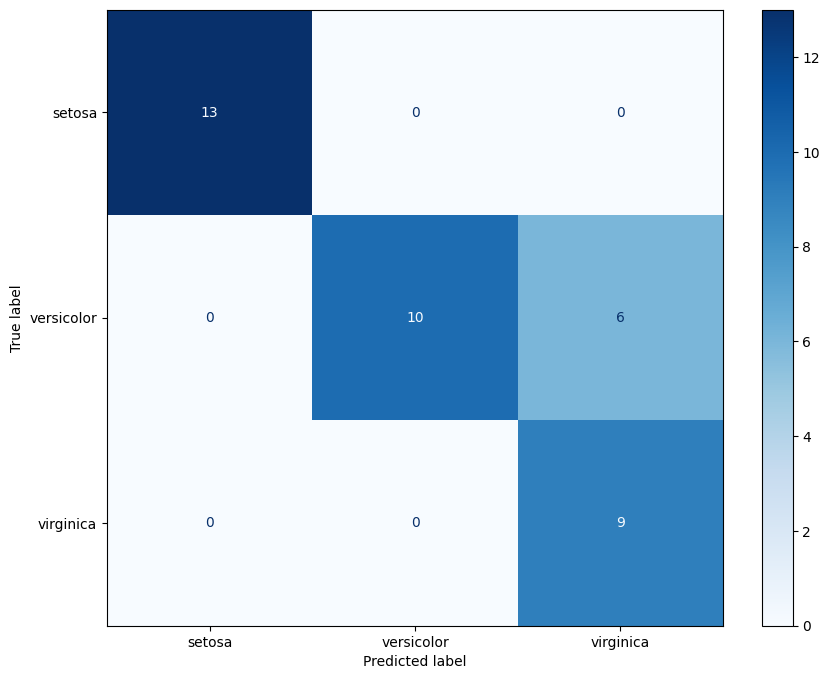

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay

# import and split the data
iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# define the classifier and fit it
classifier = svm.SVC(kernel='linear', C=0.01).fit(X_train, y_train)

# create the plot
fig, ax = plt.subplots(1, figsize=(10, 8))
_ = ConfusionMatrixDisplay.from_estimator(
    classifier, 
    X_test, 
    y_test, 
    display_labels=iris.target_names, 
    cmap=plt.cm.Blues,
    ax=ax
)

### Classification Report
With the [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) function, it is possible to generate a text report that includes the most important classification metrics.  


In [22]:
from sklearn.metrics import classification_report

y_true = [0, 1, 2, 2, 0]
y_pred = [0, 0, 2, 1, 0]
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.67      1.00      0.80         2
     class 1       0.00      0.00      0.00         1
     class 2       1.00      0.50      0.67         2

    accuracy                           0.60         5
   macro avg       0.56      0.50      0.49         5
weighted avg       0.67      0.60      0.59         5



Further information on metrics can be found [here](https://scikit-learn.org/stable/modules/model_evaluation.html#).  


---

Lecture: AI I - Basics 

Exercise: [**Exercise 4.3: Evaluation with scikit-learn**](../04_ml/exercises/03_evaluation.ipynb)

Next: [**Chapter 5.1: Assesment 1**]()